# Introduction to Quantitative Finance

Copyright (c) 2019 Python Charmers Pty Ltd, Australia, <https://pythoncharmers.com>. All rights reserved.

<img src="img/python_charmers_logo.png" width="300" alt="Python Charmers Logo">

Published under the Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) license. See `LICENSE.md` for details.

Sponsored by Tibra Global Services, <https://tibra.com>

<img src="img/tibra_logo.png" width="300" alt="Tibra Logo">


## Module 1.6: Time Series

### 1.6.3 White Noise

In short, a time series is white noise if it is random and unpredictable.

As with most mathematical terms, it is more formally defined. A time series $X$ is white noise if it:

* has a mean of zero, that is $E[X] = 0$
* the variance is constant over time
* There is no correlation within the data at different lag periods: $E[X_t X_{t-k}] = 0$ when $k \neq 0$

To test formally if "variance is constant over time":

Let $\gamma_k = E[(X_t - \mu)(X_{t-k} - \mu)]$

$\rho_k = \frac{\gamma_k}{\gamma_0}$

The data is stationary if $\rho_k \rightarrow 0$ as $k \rightarrow \infty$, and it is white noise if also     $\frac{\rho_k}{m} \sim N(0, 1)$, where $m= \sqrt{\frac{1}{n}}$

Additionally the term *independent white noise* is also used when the variables in multivariable model are independent and have no correlation. Note that some require this as part of the test for "white noise" itself, but it is normally considered a stronger assumption than normally for "white noise".

Let's have a look at the most random of data series, and what type of statistics we can glean to see if it is white noise:

In [2]:
%run setup.ipy

In [3]:
from scipy.stats import norm

distribution = norm(0, 1)

In [4]:
np.random.seed(100)  # For consistent results. Remove this line to get random results
X = distribution.rvs(3000)  # Random data, between 0 and 1, then with 0.5 subtracted
# Note we are considering this as a "time series" data, so X[1] happens after X[0]

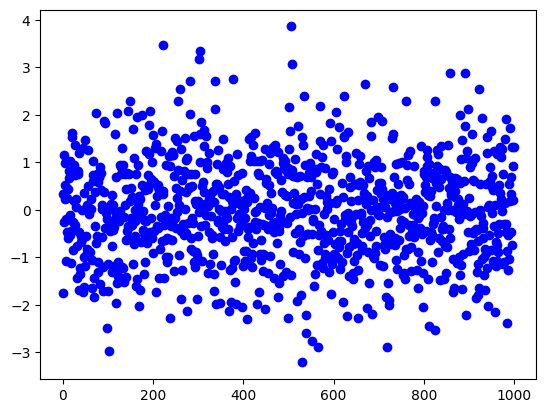

In [5]:
plt.plot(X[:1000], 'bo')

In [7]:
np.mean(X)  # Expected value is about 0. Your values may differ - try a larger sample size!

0.021943786501463503

In [8]:
import statsmodels.stats.api as sms

In [9]:
results = sms.DescrStatsW(X)

In [10]:
results.tconfint_mean(0.05)

(-0.014453270331154726, 0.05834084333408173)

Here, 0.0 does sit within the percentage bounds, so we cannot reject the hypothesis that the data has a non-zero mean.

Another way to compute this is by taking many samples of the data, computing the mean of each sample, and obtaining the bounds by finding the relevant confidence intervals.

Specifically, we need to take a bootstrap sample, which for a dataset of size $n$ is a sample of size $n$ with replacement.

In [11]:
bootstrap_sample = np.random.choice(X, size=len(X), replace=True)

We do this many times (for a large number for "many", say 100,000) and compute our statistic of interest for each sample:

In [18]:
N_ITERATIONS = 100000

means = []

for i in range(N_ITERATIONS):
    bootstrap_sample = np.random.choice(X, size=len(X), replace=True) 
    means.append(np.mean(bootstrap_sample))

We then sort the discovered statistic values, and get the lower and upper bounds, by finding the spot where y% of the values sit within those bounds. For a confidence interval of 95%, we get the 2.5% highest values and the 97.5% highest value for our statistic:

In [19]:
lower_index = int(0.025 * N_ITERATIONS)   # Hint: try without the call to int
upper_index = int(0.975 * N_ITERATIONS)

In [20]:
sorted_means = np.array(sorted(means))
lower_bounds = sorted_means[lower_index]
upper_bounds = sorted_means[upper_index]

In [21]:
lower_bounds, upper_bounds

(-0.01434853490028654, 0.058486871505393195)

Again, as zero is within the bounds, we cannot reject the hypothesis that the actual mean of the data is zero. This would be sufficient to continue with our test for white noise.

#### Exercise

The constant variance tests in `statsmodels` are not well documented and poorly implemented for directly calling them functions. Instead, use the `scipy` methods for computing constant variance, such as using Bartlett’s and Levene's test. That said, in both cases, these functions don't actually give us the value we are looking for. Instead, they tell whether two datasets have the same variance. A way to use this is to test the first half of the data against the second half.

Check the documentation for these two methods, and use the more robust of the two to perform the above test. 

#### Extended Exercise

Note that this test will not work for seasonality issues, like a year's worth of data with a higher summer value.
To visually inspect this, we plot the results of the residuals (errors) of our fitted model (such as a linear regression), and visually inspect for patterns. If a clear pattern exists, then we do not have a constant variance (constant variance in error is equivalent).

The most useful plot for determining this is residuals on the y-axis, and *fitted values* on the x-axis, i.e what your OLS model predicts for a given input. Create this plot for our `X` data, after generating a random `y` predictor variable.

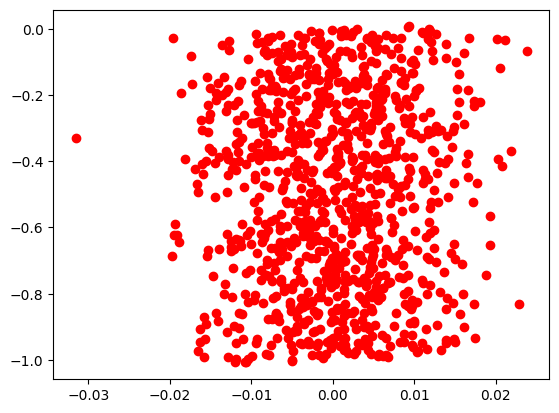

In [12]:
X = distribution.rvs(1000)  # Random data, between 0 and 1, then with 0.5 subtracted
# Note we are considering this as a "time series" data, so X[1] happens after X[0]

#From solutions
from scipy import stats

n = int(len(X) / 2)

stats.levene(X[:n], X[n:])

# Extended exercise solution
import statsmodels.api as sm

# Create some random 
y = np.random.random(len(X))
est = sm.OLS(y, X).fit()

y_pred = est.fittedvalues

residuals = y_pred - y

plt.plot(y_pred, residuals, 'ro')  # No clear pattern == white noise

*For solutions, see `solutions/residual_plotting.py`*

### Checking for autocorrelation

We can check the autocorrelation using Panda's `autocorrelate` function:

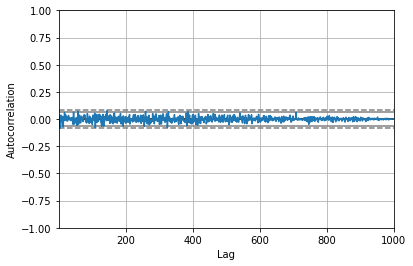

In [34]:
pd.plotting.autocorrelation_plot(X)

If no statistically significant values are above the confidence lines, then there is no autocorrelation in the data. Occasionally you will see a value appear outside these bounds - if it isn't over by too much, and doesn't happen regularly, this can be a fluke in the dataset. You can check this by doing the same plot on a bootstrapped sample of X - if it still happens, then investigate further for autocorrelation.

#### Exercise

Create a dataset with one variable that violates each of the three requirements for white noise. Plot the data to visually see the results. and plot the autocorrelation plot.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

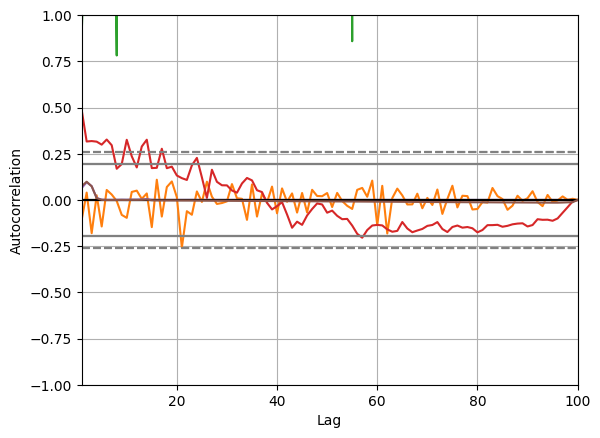

In [14]:
#From solutions

# Mean not 0

X = np.random.random(100) + 10  # Mean is about 10.5

plt.plot(X)

pd.plotting.autocorrelation_plot(X)

# Variance not constant

i = np.arange(100)
X = np.random.random(len(i)) * i

plt.plot(X)

pd.plotting.autocorrelation_plot(X)

# Lagged correlation
X = [1] * 100
for i in range(1, 100):
    X[i] = X[i-1] * np.random.random() * 2
    
plt.plot(X)

pd.plotting.autocorrelation_plot(X)


*For solutions, see `solutions/white_noise_break.py`*